In [1]:
import altair as alt
import networkx as nx
import numpy as np
import pandas as pd
import sys
".." not in sys.path and sys.path.append("..")

from faker import Faker
from alph import alph, layers, layout, util

util.set_altair_renderer()

Let's generate some data:

- a graph made up of interaction patterns
- some fake names
- a centrality measure
- a couple of categories - jobs and countries


In [2]:
seed = 321
np_random = np.random.RandomState(seed)
Faker.seed(seed)
fake = Faker("en_uk")

jobs = [fake.job() for _ in range(8)]
countries = [fake.country() for _ in range(4)]

G = util.generate_interaction_graph(
    nodes=list("abcdefghijklmnopqrstuvwxyz"), mean_time_between_interactions=1, seed=seed
)

nx.set_node_attributes(G, {
    n: {
        "id": n,
        "name": fake.first_name(),
        "job": np_random.choice(jobs),
        "country": np_random.choice(countries, p=[0.4, 0.3, 0.2, 0.1]),
    } for n in G.nodes()
})
nx.set_node_attributes(G, nx.degree_centrality(G), "degree_centrality")

print(f"G: {len(G.nodes)} node(s), {len(G.edges)} edge(s)")

G: 26 node(s), 32 edge(s)


Simple customisation - custom layout and styling

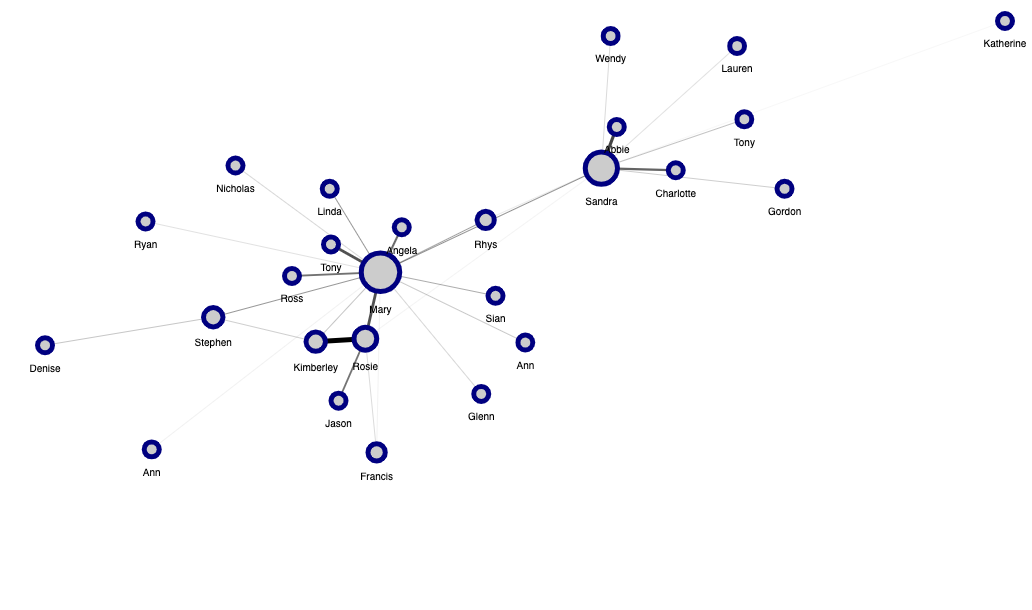

In [6]:
alph(
    G,
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=3, iterations=5000, seed=seed),
    node_args=dict(
        size=alt.Size("degree_centrality", scale=alt.Scale(domain=[0,1], range=[150, 2000]), legend=None),
        fill="#ccc",
        stroke="navy",
        strokeWidth=5,
        tooltip_attrs=["name"],
        label_attr="name",
    ),
    edge_args=dict(color="black"),
    width=1000, height=600,
).configure_view(strokeWidth=0)

Simple customisation - conditionally highlight nodes and edges

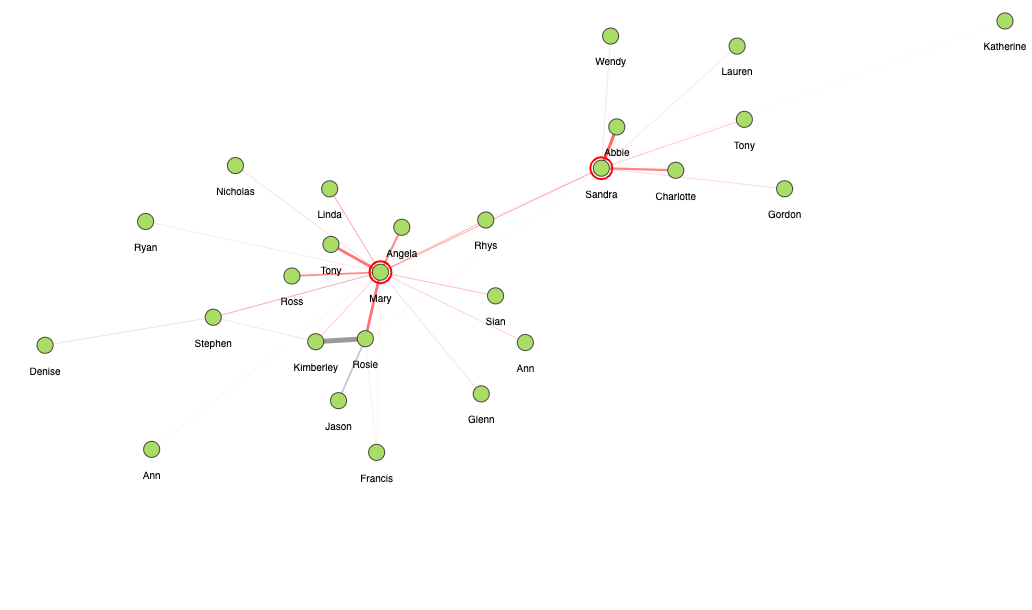

In [4]:
alph(
    G,
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=3, iterations=5000, seed=seed),
    node_args=dict(
        size=(8*2) ** 2,
        fill="#ad6",
        stroke="#444",
        strokeWidth=1,
        halo_offset=2,
        halo_opacity=alt.condition(
            "(datum.name == 'Mary') || (datum.name == 'Sandra')",
            alt.value(1),
            alt.value(0)
        ),
        halo_stroke="red",
        halo_strokeWidth=2,
        tooltip_attrs=["name", "id"],
        label_attr="name",
    ),
    edge_args=dict(
        color=alt.condition(
            (
                (alt.datum.source == 'c')
                | (alt.datum.target == 'c')
                | (alt.datum.source == 'b')
                | (alt.datum.target == 'b')
            ),
            alt.value("#f33"),
            alt.value("#999")
        ),
    ),
    width=1000, height=600,
).configure_view(strokeWidth=0)

Combination of two plots altair-style, showing the use of Altair settings

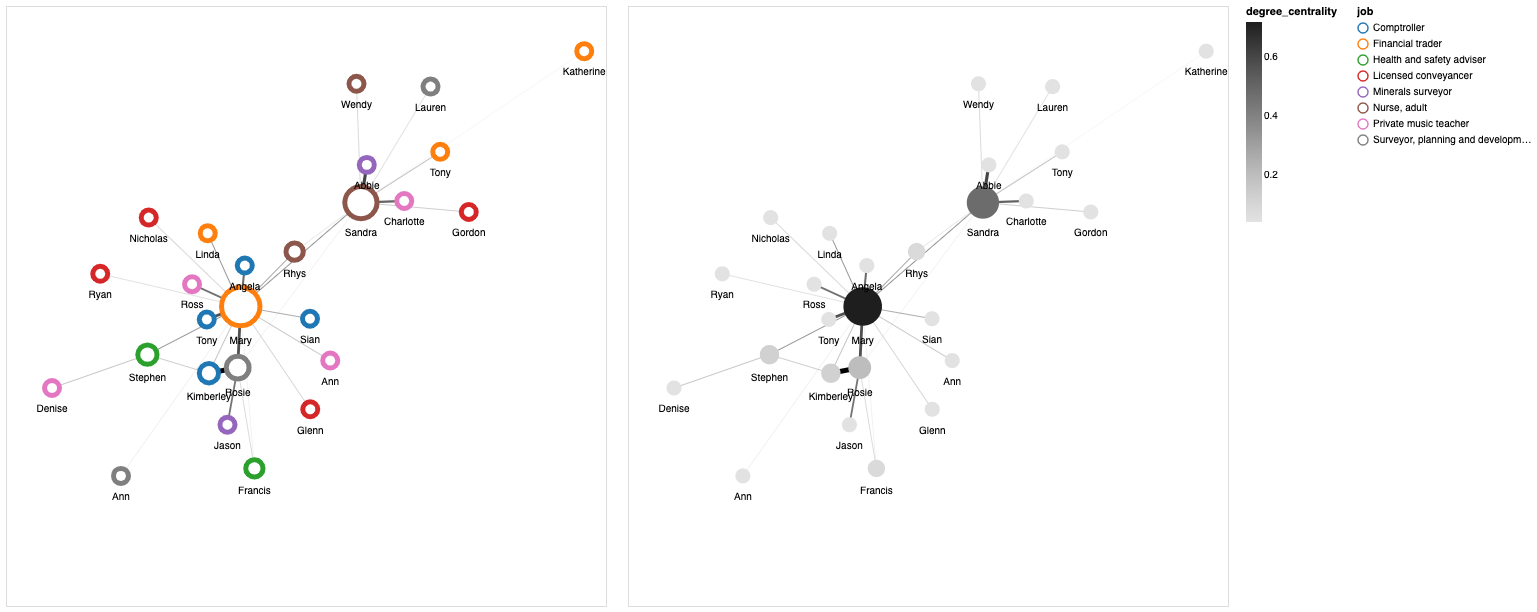

In [8]:
g1 = alph(
    G,
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=4, iterations=5000, seed=seed),
    node_args=dict(
        size=alt.Size(
            "degree_centrality",
            scale=alt.Scale(domain=[0,1], range=[150, 2000]),
            legend=None
        ),
        fill="#fff",
        stroke=alt.Color("job", scale=alt.Scale(scheme="category10")),
        strokeWidth=5,
        tooltip_attrs=["name", "job", "country"],
        label_attr="name",
    ),
    edge_args=dict(color="black"),
    width=600,
    height=600,
    padding=20,
)

g2 = alph(
    G,
    weight_attr="weight",
    layout_fn=lambda g: nx.spring_layout(g, weight="weight", k=4, iterations=5000, seed=seed),
    node_args=dict(
        size=alt.Size(
            "degree_centrality",
            scale=alt.Scale(domain=[0,1], range=[150, 2000]),
            legend=None
        ),
        fill=alt.Color("degree_centrality", scale=alt.Scale(scheme="greys")),
        stroke=alt.Color("job", scale=alt.Scale(scheme="category10")),
        strokeWidth=0,
        tooltip_attrs=["name", "job", "country"],
        label_attr="name",
    ),
    edge_args=dict(color="black"),
    width=600,
    height=600,
    padding=20,
)

g1 | g2